In [27]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import zipfile
import os
import shutil
import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


MODEL CLASS

In [33]:


class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.Linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.Linear(x)

        return x

model = AlexNet()
model = model.to(device=device)


DATA LOADER

In [29]:
# mkdir data
# wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip or download and place it in the folder you just made

with zipfile.ZipFile("data/celeba.zip", "r") as zip_ref:
    zip_ref.extractall("data/")

root = 'data/img_align_celeba'

img_list = os.listdir(root)
print(len(img_list))


KeyboardInterrupt: 

In [ ]:

df = pd.read_csv('data/list_attr_celeba.csv')
df = df[["image_id", "Smiling"]]

df

s0 = 0
s1 = 0
num = 2200


for i, (_, i_row) in enumerate(df.iterrows()):
    if s0 < num:
        if i_row['Smiling'] == 1:
            s0 += 1
            shutil.copyfile('data/img_align_celeba/' +
                            i_row['image_id'], 'classes/smile/' + i_row['image_id'])

    if s1 < num:
        if i_row['Smiling'] == -1:
            s1 += 1
            shutil.copyfile('data/img_align_celeba/' +
                            i_row['image_id'], 'classes/no_smile/' + i_row['image_id'])


img_list = os.listdir('classes/smile/')
img_list.extend(os.listdir('classes/no_smile/'))
print(len(img_list))

4400


In [ ]:
# Defining Transforms and setting our dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

batch_size = 64
celeba_data = datasets.ImageFolder('classes', transform=transform)

print(celeba_data.classes)
print(len(celeba_data))

train_size = int(len(img_list)*0.8)
test_size = int(len(img_list)*0.2)

train_set, test_set = torch.utils.data.random_split(
    celeba_data, [train_size, test_size])

trainLoader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True)


['no_smile', 'smile']
4400


Epoch: 0 | Train Loss: 0.604098350351507
Epoch: 1 | Train Loss: 0.6000076944177801
Epoch: 2 | Train Loss: 0.5934134407476945
Epoch: 3 | Train Loss: 0.5912481037053194
Epoch: 4 | Train Loss: 0.5836467948826877
Epoch: 5 | Train Loss: 0.5742929231036793
Epoch: 6 | Train Loss: 0.5640650700439106
Epoch: 7 | Train Loss: 0.5561865996230733
Epoch: 8 | Train Loss: 0.5492165993560444
Epoch: 9 | Train Loss: 0.535982160134749
Epoch: 10 | Train Loss: 0.5186828434467315
Epoch: 11 | Train Loss: 0.5164480203931981
Epoch: 12 | Train Loss: 0.4916319202293049
Epoch: 13 | Train Loss: 0.4830478993329135
Epoch: 14 | Train Loss: 0.4718762468207966
Epoch: 15 | Train Loss: 0.4558770331469449
Epoch: 16 | Train Loss: 0.45406217141584915
Epoch: 17 | Train Loss: 0.4317659475586631
Epoch: 18 | Train Loss: 0.4227139873938127
Epoch: 19 | Train Loss: 0.41262126023119144
Epoch: 20 | Train Loss: 0.403899930823933
Epoch: 21 | Train Loss: 0.39408290494572035
Epoch: 22 | Train Loss: 0.40189286064017904
Epoch: 23 | Train Lo

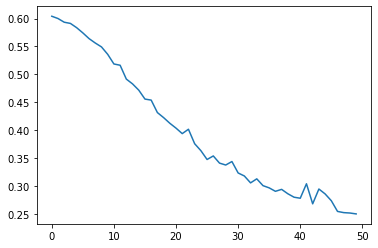

In [42]:

optimizer = optim.Adam(model.parameters(), lr=0.0000035)
# optimizer = optim.SGD(model.parameters(), lr=0.0000001)

criterion = nn.CrossEntropyLoss()
epochs = 50


train_loss = []


for epoch in range(epochs):
    total_train_loss = 0

    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

plt.plot(train_loss)


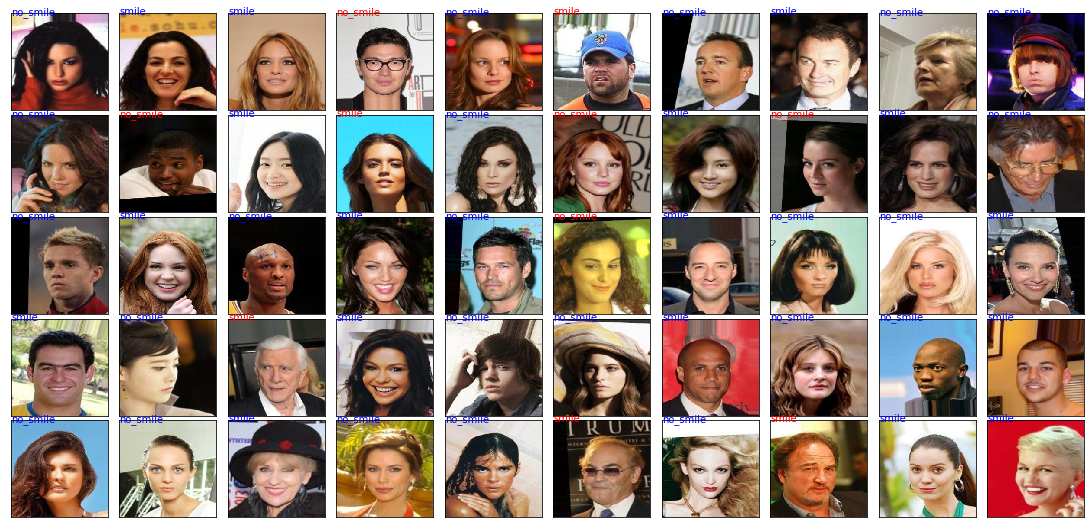

In [43]:

testiter = iter(testLoader)
images, labels = testiter.next()

with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

images_np = [i.cpu() for i in images]
class_names = celeba_data.classes


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0),
              cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')
